# TMDB Box Office Prediction

***

[Import and Load](#Import-and-Load)
    
[Data Cleaning](#Data-Cleaning)
    
[Exploratory Data Analysis](#Exploratory-Data-Analysis)
    
[Feature Engineering](#Feature-Engineering)
    
[Descriptive Statistics](#Descriptive-Statistics)

[Feature Selection](#Feature-Selection)
    
[Predict and Evaluate](#Predict-and-Evaluate)

***

### Import and Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import itertools
import ast
import warnings

import xgboost as xgb
#import catboost as cat
#import lightgbm as lgb

#from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split, KFold, GroupKFold, StratifiedKFold, cross_validate, cross_val_score
from sklearn.decomposition import PCA#, TruncatedSVD
#from sklearn.preprocessing import Normalizer, LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, Imputer

#from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesClassifier
#from sklearn.datasets import make_classification

#from sklearn.neighbors import KNeighborsRegressor
#from functools import reduce
#from sklearn import (datasets,discriminant_analysis, neighbors)
from sklearn.linear_model import LinearRegression#, ElasticNetCV

#import json
#import operator
#import time
#import os

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100)

seed = 42

In [2]:
#import sys
#import pip
#!{sys.executable} -m pip install xgboost

In [3]:
#load data
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#drop some columns I won't be analysing at the moment
df_raw = df.drop(['poster_path','homepage','tagline','status'], axis = 1)
test_raw = test.drop(['poster_path','homepage','tagline','status'], axis = 1)

df = df_raw.copy()
test = test_raw.copy()
both = pd.concat([df, test], axis=0)


In [4]:
#look at the data
both.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 0 to 4397
Data columns (total 19 columns):
Keywords                 6729 non-null object
belongs_to_collection    1481 non-null object
budget                   7398 non-null int64
cast                     7372 non-null object
crew                     7360 non-null object
genres                   7375 non-null object
id                       7398 non-null int64
imdb_id                  7398 non-null object
original_language        7398 non-null object
original_title           7398 non-null object
overview                 7376 non-null object
popularity               7398 non-null float64
production_companies     6984 non-null object
production_countries     7241 non-null object
release_date             7397 non-null object
revenue                  3000 non-null float64
runtime                  7392 non-null float64
spoken_languages         7336 non-null object
title                    7395 non-null object
dtypes: float64(3)

,id,belongs_to_collection,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


### Data Cleaning

In [5]:
#check NaN distribution
both.isna().sum().sort_values()

original_title              0
budget                      0
popularity                  0
original_language           0
imdb_id                     0
id                          0
release_date                1
title                       3
runtime                     6
overview                   22
genres                     23
cast                       26
crew                       38
spoken_languages           62
production_countries      157
production_companies      414
Keywords                  669
revenue                  4398
belongs_to_collection    5917
dtype: int64

In [6]:
#replace runtime NaNs
df.runtime.replace(np.nan,0 ,inplace=True)
test.runtime.replace(np.nan,0 ,inplace=True)

both = pd.concat([df, test], axis=0)

In [7]:
#check for unrealistic budget, revenue and runtime values

print('Budget is zero: ' + str(both[both['budget']==0].shape[0]))
      
print('Non-zero Budget under 1000: '+ str(both[(both['budget']>0) & (both['budget']<1000)].shape[0]))

print('\nRevenue is zero: ' + str(df[df['revenue']==0].shape[0]))
      
print('Non-zero Revenue under 1000: '+ str(df[(df['revenue']>0) & (df['revenue']<1000)].shape[0]))

print('\nRuntime is zero: ' + str(both[both['runtime']==0].shape[0]))
      
print('Non-zero Runtime under 30: '+ str(both[(both['runtime']>0) & (both['runtime']<30)].shape[0]))


Budget is zero: 2023
Non-zero Budget under 1000: 52

Revenue is zero: 0
Non-zero Revenue under 1000: 57

Runtime is zero: 27
Non-zero Runtime under 30: 3


In [8]:
df = df_raw.copy()
test = test_raw.copy()
both = pd.concat([df, test], axis=0)

#load further movie data

imdb_raw = pd.read_csv('movie_metadata.csv')

#Prepare imdb data

imdb_links = imdb_raw.movie_imdb_link.to_string(index=False).split('http://www.imdb.com/title/')[1:]
imdb_ids=[]

for i in imdb_links:
    imdb_ids.append(i[:9])

imdb_raw['imdb_id']=imdb_ids
imdb_raw.rename(columns = {'movie_title':'title','title_year':'year','director_name':'director','actor_1_name':'actor_1','actor_2_name':'actor_2','duration':'runtime2','gross':'revenue2','budget':'budget2'}, inplace = True)

imdb_b = imdb_raw[['imdb_id','budget2']].copy()
imdb_r = imdb_raw[['imdb_id','revenue2']].copy()
imdb_d = imdb_raw[['imdb_id','runtime2']].copy()


def add_info(tmp,e,cat,l):
    e.drop_duplicates(subset='imdb_id', inplace=True)
    e.dropna(inplace=True)
    
    #make df with an extra columnd for the info from e
    d = pd.merge(tmp, e, how='left', on='imdb_id')
    
    d[cat].replace(0, np.nan, inplace=True)
    d[cat+'2'].replace(0, np.nan, inplace=True)
    
    #fill the NaNs with the values from the other dataset
    d.loc[d[cat].isnull(),cat] = d[cat+'2']
    d.loc[d[cat+'2'].isnull(),cat+'2'] = d[cat]
    
    d[cat].replace(np.nan, 0,inplace=True)
    d[cat+'2'].replace(np.nan, 0,inplace=True)
    
    #keep the column with the fewest unrealistic values
    if d[d[cat]<l].shape[0] > d[d[cat+'2']<l].shape[0]:
        d[cat] = d[cat+'2']
    
    return d.drop(cat+'2',axis=1)


In [9]:
df =add_info(df.copy(),imdb_b,'budget',1000)
test =add_info(test.copy(),imdb_b,'budget',1000)

df =add_info(df.copy(),imdb_d,'runtime',30)
test =add_info(test.copy(),imdb_d,'runtime',30)

df =add_info(df.copy(),imdb_r,'revenue',1000)

both = pd.concat([df.copy(), test.copy()], axis=0)

#check again

print('Budget is zero: ' + str(both[both['budget']==0].shape[0]))
      
print('Non-zero Budget under 1000: '+ str(both[(both['budget']>0) & (both['budget']<1000)].shape[0]))

print('\nRevenue is zero: ' + str(df[df['revenue']==0].shape[0]))
      
print('Non-zero Revenue under 1000: '+ str(df[(df['revenue']>0) & (df['revenue']<1000)].shape[0]))

print('\nRuntime is zero: ' + str(both[both['runtime']==0].shape[0]))
      
print('Non-zero Runtime under 20: '+ str(both[(both['runtime']>0) & (both['runtime']<30)].shape[0]))


Budget is zero: 1954
Non-zero Budget under 1000: 39

Revenue is zero: 0
Non-zero Revenue under 1000: 49

Runtime is zero: 27
Non-zero Runtime under 20: 3


In [10]:
#check for unrealistic runtime values, and print their ids, imdb_ids (to google) and titles

pd.concat([df[df['runtime']<30],test[test['runtime']<30]],axis=0)[['id','title','imdb_id','runtime']]

,id,title,imdb_id,runtime
390,391,The Worst Christmas of My Life,tt2550838,0.0
591,592,А поутру они проснулись,tt0768690,0.0
924,925,¿Quién mató a Bambi?,tt2604346,0.0
977,978,La peggior settimana della mia vita,tt2076251,0.0
1255,1256,"Cry, Onion!",tt0072785,0.0
1335,1336,Королёв,tt1107828,0.0
1541,1542,All at Once,tt3805180,0.0
1874,1875,Missing,tt1133617,0.0
2150,2151,Mechenosets,tt0477337,0.0
2302,2303,Happy Weekend,tt0116485,0.0


In [11]:
#manually correct runtime values by googling imdb id

#train data
df.runtime[df.id == 1336]= 130 #Королёв
df.runtime[df.id == 2303]= 90 #Happy Weekend
df.runtime[df.id == 391] = 86 #Il peor natagle de la meva vida
df.runtime[df.id == 592] = 90 #А поутру они проснулись
df.runtime[df.id == 925] = 95 #¿Quién mató a Bambi?
df.runtime[df.id == 978] = 93 #La peggior settimana della mia vita
df.runtime[df.id == 1256] = 92 #Cipolla Colt
df.runtime[df.id == 1542] = 93 #Все и сразу
df.runtime[df.id == 1875] = 86 #Vermist
df.runtime[df.id == 2151] = 108 #Mechenosets
df.runtime[df.id == 2499] = 108 #Na Igre 2. Novyy Uroven
df.runtime[df.id == 2646] = 98 #同桌的妳
df.runtime[df.id == 2786] = 111 #Revelation
df.runtime[df.id == 2866] = 96 #Tutto tutto niente niente

#test data:
test.runtime[test.id ==3244] =93 #La caliente niña Julietta
test.runtime[test.id ==4490] =91 #Pancho, el perro millonario
test.runtime[test.id ==4633] =100 #Nunca en horas de clase
test.runtime[test.id ==6818] =90 #Miesten välisiä keskusteluja
test.runtime[test.id == 4074] = 103 #Shikshanachya Aaicha Gho
test.runtime[test.id == 4222] = 93 #Street Knight
test.runtime[test.id == 4431] = 100 #Плюс один
test.runtime[test.id == 5520] = 86 #Glukhar v kino
test.runtime[test.id == 5845] = 83 #Frau Müller muss weg!
test.runtime[test.id == 5849] = 140 #Shabd
test.runtime[test.id == 6210] = 104 #Le dernier souffle
test.runtime[test.id == 6804] = 145 #Chaahat Ek Nasha..
test.runtime[test.id == 7321] = 87 #El truco del manco

# add the few missing titles and release dates
test.title[test.id ==5399]='The Life of Guskou Budori'
test.title[test.id ==5426]='Would I Lie to You? 3'
test.title[test.id ==6629]='Barefoot'
test.release_date[test.id ==3829]= '3/20/01'

#
df1 = df.copy()
test1 = test.copy()
both1 = pd.concat([df.copy(), test.copy()], axis=0)

In [12]:
#checkpoint
df = df1.copy()
test = test1.copy()
both = pd.concat([df1.copy(), test1.copy()], axis=0)

#Further corrected values copy pasted from this kernel  https://www.kaggle.com/zero92/tmdb-prediction
#author apparently got this values "By requesting a key on the TMDB website in order to scrape 
#theirs data with their authorization"
#I checked out a couple and they seem to be fine except for the ones in a lower range, many of 
#which seem to be missing a few zeros.

s1 ='''
train.loc[train['id'] == 90,'budget'] = 30000000                  
train.loc[train['id'] == 118,'budget'] = 60000000       
train.loc[train['id'] == 149,'budget'] = 18000000       
train.loc[train['id'] == 464,'budget'] = 20000000       
train.loc[train['id'] == 470,'budget'] = 13000000       
train.loc[train['id'] == 513,'budget'] = 930000         
train.loc[train['id'] == 797,'budget'] = 8000000        
train.loc[train['id'] == 819,'budget'] = 90000000       
train.loc[train['id'] == 850,'budget'] = 90000000       
train.loc[train['id'] == 1007,'budget'] = 2              
train.loc[train['id'] == 1112,'budget'] = 7500000       
train.loc[train['id'] == 1131,'budget'] = 4300000        
train.loc[train['id'] == 1359,'budget'] = 10000000       
train.loc[train['id'] == 1542,'budget'] = 1             
train.loc[train['id'] == 1570,'budget'] = 15800000       
train.loc[train['id'] == 1571,'budget'] = 4000000        
train.loc[train['id'] == 1714,'budget'] = 46000000       
train.loc[train['id'] == 1721,'budget'] = 17500000       
train.loc[train['id'] == 1885,'budget'] = 12             
train.loc[train['id'] == 2091,'budget'] = 10             
train.loc[train['id'] == 2268,'budget'] = 17500000       
train.loc[train['id'] == 2491,'budget'] = 6              
train.loc[train['id'] == 2602,'budget'] = 31000000       
train.loc[train['id'] == 2612,'budget'] = 15000000       
train.loc[train['id'] == 2696,'budget'] = 10000000      
train.loc[train['id'] == 2801,'budget'] = 10000000       
train.loc[train['id'] == 335,'budget'] = 2 
train.loc[train['id'] == 348,'budget'] = 12
train.loc[train['id'] == 470,'budget'] = 13000000 
train.loc[train['id'] == 513,'budget'] = 1100000
train.loc[train['id'] == 640,'budget'] = 6 
train.loc[train['id'] == 696,'budget'] = 1
train.loc[train['id'] == 797,'budget'] = 8000000 
train.loc[train['id'] == 850,'budget'] = 1500000
train.loc[train['id'] == 1199,'budget'] = 5 
train.loc[train['id'] == 1282,'budget'] = 9              
train.loc[train['id'] == 1347,'budget'] = 1
train.loc[train['id'] == 1755,'budget'] = 2
train.loc[train['id'] == 1801,'budget'] = 5
train.loc[train['id'] == 1918,'budget'] = 592 
train.loc[train['id'] == 2033,'budget'] = 4
train.loc[train['id'] == 2118,'budget'] = 344 
train.loc[train['id'] == 2252,'budget'] = 130
train.loc[train['id'] == 2256,'budget'] = 1 
train.loc[train['id'] == 2696,'budget'] = 10000000
'''

s2 ='''
test.loc[test['id'] == 3033,'budget'] = 250 
test.loc[test['id'] == 3051,'budget'] = 50
test.loc[test['id'] == 3084,'budget'] = 337
test.loc[test['id'] == 3224,'budget'] = 4  
test.loc[test['id'] == 3594,'budget'] = 25  
test.loc[test['id'] == 3619,'budget'] = 500  
test.loc[test['id'] == 3831,'budget'] = 3  
test.loc[test['id'] == 3935,'budget'] = 500  
test.loc[test['id'] == 4049,'budget'] = 995946 
test.loc[test['id'] == 4424,'budget'] = 3  
test.loc[test['id'] == 4460,'budget'] = 8  
test.loc[test['id'] == 4555,'budget'] = 1200000 
test.loc[test['id'] == 4624,'budget'] = 30 
test.loc[test['id'] == 4645,'budget'] = 500 
test.loc[test['id'] == 4709,'budget'] = 450 
test.loc[test['id'] == 4839,'budget'] = 7
test.loc[test['id'] == 3125,'budget'] = 25 
test.loc[test['id'] == 3142,'budget'] = 1
test.loc[test['id'] == 3201,'budget'] = 450
test.loc[test['id'] == 3222,'budget'] = 6
test.loc[test['id'] == 3545,'budget'] = 38
test.loc[test['id'] == 3670,'budget'] = 18
test.loc[test['id'] == 3792,'budget'] = 19
test.loc[test['id'] == 3881,'budget'] = 7
test.loc[test['id'] == 3969,'budget'] = 400
test.loc[test['id'] == 4196,'budget'] = 6
test.loc[test['id'] == 4221,'budget'] = 11
test.loc[test['id'] == 4222,'budget'] = 500
test.loc[test['id'] == 4285,'budget'] = 11
test.loc[test['id'] == 4319,'budget'] = 1
test.loc[test['id'] == 4639,'budget'] = 10
test.loc[test['id'] == 4719,'budget'] = 45
test.loc[test['id'] == 4822,'budget'] = 22
test.loc[test['id'] == 4829,'budget'] = 20
test.loc[test['id'] == 4969,'budget'] = 20
test.loc[test['id'] == 5021,'budget'] = 40 
test.loc[test['id'] == 5035,'budget'] = 1 
test.loc[test['id'] == 5063,'budget'] = 14 
test.loc[test['id'] == 5119,'budget'] = 2 
test.loc[test['id'] == 5214,'budget'] = 30 
test.loc[test['id'] == 5221,'budget'] = 50 
test.loc[test['id'] == 4903,'budget'] = 15
test.loc[test['id'] == 4983,'budget'] = 3
test.loc[test['id'] == 5102,'budget'] = 28
test.loc[test['id'] == 5217,'budget'] = 75
test.loc[test['id'] == 5224,'budget'] = 3 
test.loc[test['id'] == 5469,'budget'] = 20 
test.loc[test['id'] == 5840,'budget'] = 1 
test.loc[test['id'] == 5960,'budget'] = 30
test.loc[test['id'] == 6506,'budget'] = 11 
test.loc[test['id'] == 6553,'budget'] = 280
test.loc[test['id'] == 6561,'budget'] = 7
test.loc[test['id'] == 6582,'budget'] = 218
test.loc[test['id'] == 6638,'budget'] = 5
test.loc[test['id'] == 6749,'budget'] = 8 
test.loc[test['id'] == 6759,'budget'] = 50 
test.loc[test['id'] == 6856,'budget'] = 10
test.loc[test['id'] == 6858,'budget'] =  100
test.loc[test['id'] == 6876,'budget'] =  250
test.loc[test['id'] == 6972,'budget'] = 1
test.loc[test['id'] == 7079,'budget'] = 8000000
test.loc[test['id'] == 7150,'budget'] = 118
test.loc[test['id'] == 6506,'budget'] = 118
test.loc[test['id'] == 7225,'budget'] = 6
test.loc[test['id'] == 7231,'budget'] = 85
test.loc[test['id'] == 5222,'budget'] = 5
test.loc[test['id'] == 5322,'budget'] = 90
test.loc[test['id'] == 5350,'budget'] = 70
test.loc[test['id'] == 5378,'budget'] = 10
test.loc[test['id'] == 5545,'budget'] = 80
test.loc[test['id'] == 5810,'budget'] = 8
test.loc[test['id'] == 5926,'budget'] = 300
test.loc[test['id'] == 5927,'budget'] = 4
test.loc[test['id'] == 5986,'budget'] = 1
test.loc[test['id'] == 6053,'budget'] = 20
test.loc[test['id'] == 6104,'budget'] = 1
test.loc[test['id'] == 6130,'budget'] = 30
test.loc[test['id'] == 6301,'budget'] = 150
test.loc[test['id'] == 6276,'budget'] = 100
test.loc[test['id'] == 6473,'budget'] = 100
test.loc[test['id'] == 6842,'budget'] = 30
'''

c1 = s1.split(' == ')[1:]
c2 = s2.split(' == ')[1:]

#change values only if the current budget is smaller the 1000

for i in range(len(c1)):
    c1[i] = c1[i].split('] = ')
    c1[i][0] = eval(c1[i][0].split(',')[0])
    c1[i][1] = eval(c1[i][1].split('\n')[0].replace(" ", ""))
    df.loc[df['id'] == c1[i][0],'budget'] = df.loc[df['id'] == c1[i][0],'budget'].apply(lambda x : x if x>=1000 else c1[i][1])

for i in range(len(c2)):
    c2[i] = c2[i].split('] = ')
    c2[i][0] = eval(c2[i][0].split(',')[0])
    c2[i][1] = eval(c2[i][1].split('\n')[0].replace(" ", ""))
    test.loc[test['id'] == c2[i][0],'budget'] = test.loc[test['id'] == c2[i][0],'budget'].apply(lambda x : x if x>=1000 else c2[i][1])

df2 = df.copy()
test2 = test.copy()
both2 = pd.concat([df2.copy(), test2.copy()], axis=0)


In [13]:
#Compare Budget before and after the copypasted data

print('Before:\n')

print('Budget is zero: ' + str(both1[both1['budget']==0].shape[0]))
      
print('Non-zero Budget under 1000: '+ str(both1[(both1['budget']>0) & (both1['budget']<1000)].shape[0]))

print('\nAfter:\n')

print('Budget is zero: ' + str(both2[both2['budget']==0].shape[0]))
      
print('Non-zero Budget under 1000: '+ str(both2[(both2['budget']>0) & (both2['budget']<1000)].shape[0]))


Before:

Budget is zero: 1954
Non-zero Budget under 1000: 39

After:

Budget is zero: 1912
Non-zero Budget under 1000: 62


In [14]:
#Checks for the non-zero unrealistic values. (Commented out to avoid clutter)

##Random sample of movies with a 1-digit budget
#both[(both['budget']>0) & (both['budget']<10)].sample(n=5,random_state=123)[['id','title','imdb_id','budget']]

##All movies with a 2-digit budget
#both[(both['budget']>=10) & (both['budget']<100)][['id','title','imdb_id','budget']]
##Movies with a budget under 50 seem to be in millions

##Random sample of movies with a 3 digit budget
#both[(both['budget']>=100) & (both['budget']<1000)].sample(n=5,random_state=123)[['id','title','imdb_id','budget']]

##All movies with a 1-digit revenue
#df[(df['revenue']>0) & (df['revenue']<10)][['id','title','imdb_id','revenue']]
##They all seem to be in millions

##All movies with a 2-digit revenue
#df[(df['revenue']>=10) & (df['revenue']<100)][['id','title','imdb_id','revenue']]
##Doesn't seem so clear cut for the rest. assumption: *1000

In [15]:
df = df2.copy()
test = test2.copy()
both = pd.concat([df2.copy(), test2.copy()], axis=0)

#In most cases, the smaller numbers are in millions and the 3 digit number are in thousands

df.loc[(df['budget']>0) & (df['budget']<1000),'budget'] = df.loc[(df['budget']>0) & (df['budget']<1000),'budget'].apply(lambda x : x*1000 if x>=50 else x*1000000)

test.loc[(test['budget']>0) & (test['budget']<1000),'budget'] = test.loc[(test['budget']>0) & (test['budget']<1000),'budget'].apply(lambda x : x*1000 if x>=50 else x*1000000)

#The revenue varies much more so I will only change those under 100, and only under 10 for millions

df.loc[(df['revenue']>0) & (df['revenue']<100),'revenue'] = df.loc[(df['revenue']>0) & (df['revenue']<100),'revenue'].apply(lambda x : x*1000 if x>=10 else x*1000000)

both = pd.concat([df.copy(), test.copy()], axis=0)

df_corrected = df.copy()
test_corrected = test.copy()
both_corrected = both.copy()

In [16]:
#look at categories in dic form.

cats =['belongs_to_collection','genres','production_companies','production_countries','Keywords','spoken_languages','crew','cast','overview']
    
df[cats].head(3)

#In most cases, replacing  the df with a list of the values for the 'name' category should be sufficient

,belongs_to_collection,genres,production_companies,production_countries,Keywords,spoken_languages,crew,cast,overview
0,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...","[{'id': 35, 'name': 'Comedy'}]","[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '59ac067c92514107af02c8c8', 'de...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","When Lou, who has become the ""father of the In..."
1,"[{'id': 107674, 'name': 'The Princess Diaries ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '52fe43fe9251416c7502563d', 'de...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...",Mia Thermopolis is now a college graduate and ...
2,NaN,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'iso_639_1': 'en', 'name': 'English'}]","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","Under the direction of a ruthless instructor, ..."


In [17]:
#Clean up categories, make them readable
df = df_corrected.copy()
test = test_corrected.copy()
both = both_corrected.copy()

main_languages = list(both.original_language.value_counts()[:10].index)

def get_data(d):
    
    #turn strings into lists of dics (in this case)
    for i in cats[:-1]:
        d.loc[d[i].notnull(),i]=d.loc[d[i].notnull(),i].apply(lambda x : ast.literal_eval(x))    
    
    #empty list if nan for all except collection
    for i in cats[1:]:
        d.loc[d[i].isnull(),i]=d.loc[d[i].isnull(),i].apply(lambda x : [])
    
    #turn dic into list of names for all except overview, cast and crew
    for i in cats[:-4]:
        d.loc[d[i].notnull(),i]=d.loc[d[i].notnull(),i].apply(lambda x : [y['name'] for y in x])
    
    #turn collection values into either the string of the collection's name or 0
    i = cats[0]
    d.loc[d[i].notnull(),i]=d.loc[d[i].notnull(),i].apply(lambda x : str(x[0]))
    d.loc[d[i].isnull(),i]=d.loc[d[i].isnull(),i].apply(lambda x : 0)
    
    #get code (z.B. en) instead of name (z.B. English) for spoken languages
    i=cats[-4]
    d.loc[d[i].notnull(),i]=d.loc[d[i].notnull(),i].apply(lambda x : [y['iso_639_1'] for y in x])
    
    #Change overview into list of lower case words, get rid of non-alphanumeric characters. Get length
    i=cats[-1]
    d.loc[d[i].notnull(),i]=d.loc[d[i].notnull(),i].apply(lambda x : [''.join(ch for ch in y if ch.isalnum()).lower() for y in str(x).split(' ')])
    d['len_overview']= d[i].apply(lambda x:len(x) if x!=0 else 0)
    
    #For the cast column, keep only the length and 5 most important actors
    i=cats[-2]
    d['num_cast']=d[i].apply(lambda x:len(x) if x!=0 else 0)
    
    d.loc[d[i].notnull(),i]=d.loc[d[i].notnull(),i].apply(lambda x : [y['name'] for y in x if y['order']<5])
    
    #Also get length of crew and of staff
    
    d['num_crew']=d['crew'].apply(lambda x:len(x) if x!=0 else 0)
    
    d['num_staff']= d['num_crew']+d['num_cast']
    
    #Make categories for director, producer and exec producer, filled with empty lists
    i=cats[-3]
    d["director"]=[[] for i in range(d.shape[0])]
    d["producer"]=[[] for i in range(d.shape[0])]
    d["exec_producer"]=[[] for i in range(d.shape[0])]
    
    #Fill them according to job description
    d["director"]=d.loc[d[i].notnull(),i].apply(lambda x : [y["name"] for y in x if y["job"]=="Director"])
    d["producer"]=d.loc[d[i].notnull(),i].apply(lambda x : [y["name"] for y in x if y["job"]=="Producer"])
    d["exec_producer"]=d.loc[d[i].notnull(),i].apply(lambda x : [y["name"] for y in x if y["job"]=="Executive Producer"])
    
    #Get some other categories: release year, length of complete crew, whether english is spoken
    
    d[['month','day','year']]=d['release_date'].str.split('/',expand=True).replace(np.nan, 0).astype(int)
    
    d['quarter']= d['month'].apply(lambda x: int(np.ceil(x/3)))
    
    d.loc[(d['year'] > 19), 'year'] += 1900
    
    d.loc[(d['year'] <= 19), 'year'] += 2000
    
    d['decade'] = d['year'].apply(lambda x: int(np.floor(x/10)*10))
    
    d['len_title']=d['original_title'].apply(lambda x:len(x) if x!=0 else 0)
    
    d['eng'] = d.spoken_languages.apply(lambda x: 'en' in x)
    
    #Simplify spoken languages category, keep only the 10 main languages
    
    d.original_language = d.original_language.apply(lambda x: x if x in main_languages else 'other')
    
    #Normalize skewed budget with log1p function
    
    d['budget'] = np.log1p(d['budget'])
    d['budget'].replace(0, np.nan, inplace=True)
    
    #rename some stuff, drop unnecessary categories
    d.rename(columns = {'Keywords':'keywords','spoken_languages':'spoken','original_language':'language', 'production_companies':'companies','production_countries':'countries','belongs_to_collection':'collection'},inplace = True)
    
    d.index = d['id']
    
    d = d.drop(['id','release_date','day','original_title','imdb_id','crew','month'],axis=1)
    
    return d

#
#df['rev_bud'] = np.log1p((df['revenue']+1)/(df['budget']+1))

#
df=get_data(df)
test=get_data(test)

#Normalize skewed revenue with log1p function
df['rev'] = np.log1p(df['revenue'])


df['top_rev']=df.rev.apply(lambda x: 1 if x >= 17 else 0)

df =df.drop(['revenue'], axis=1)

both = pd.concat([df.copy(), test.copy()], axis=0).drop(['rev','top_rev'],axis=1)

df_clean =df.copy()
test_clean=test.copy()
both_clean = both.copy()

df.info()
df.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 27 columns):
collection       3000 non-null object
budget           2230 non-null float64
genres           3000 non-null object
language         3000 non-null object
overview         3000 non-null object
popularity       3000 non-null float64
companies        3000 non-null object
countries        3000 non-null object
runtime          3000 non-null float64
spoken           3000 non-null object
title            3000 non-null object
keywords         3000 non-null object
cast             3000 non-null object
len_overview     3000 non-null int64
num_cast         3000 non-null int64
num_crew         3000 non-null int64
num_staff        3000 non-null int64
director         3000 non-null object
producer         3000 non-null object
exec_producer    3000 non-null object
year             3000 non-null int32
quarter          3000 non-null int64
decade           3000 non-null int64
len_title        3000 n

,collection,budget,genres,language,overview,popularity,companies,countries,runtime,spoken,title,keywords,cast,len_overview,num_cast,num_crew,num_staff,director,producer,exec_producer,year,quarter,decade,len_title,eng,rev,top_rev
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Hot Tub Time Machine Collection,16.454568,[Comedy],en,"[when, lou, who, has, become, the, father, of,...",6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],93.0,[en],Hot Tub Time Machine 2,"[time travel, sequel, hot tub, duringcreditsst...","[Rob Corddry, Craig Robinson, Clark Duke, Adam...",29,24,72,96,[Steve Pink],[Andrew Panay],"[Rob Corddry, Ben Ormand, Matt Moore]",2015,1,2010,22,True,16.323701,0
2,The Princess Diaries Collection,17.504390,"[Comedy, Drama, Family, Romance]",en,"[mia, thermopolis, is, now, a, college, gradua...",8.248895,[Walt Disney Pictures],[United States of America],113.0,[en],The Princess Diaries 2: Royal Engagement,"[coronation, duty, marriage, falling in love]","[Anne Hathaway, Julie Andrews, H√©ctor Elizond...",69,20,9,29,[Garry Marshall],"[Whitney Houston, Mario Iscovich, Debra Martin...",[Ellen H. Schwartz],2004,3,2000,40,True,18.370959,1
3,0,15.009433,[Drama],en,"[under, the, direction, of, a, ruthless, instr...",64.299990,"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],105.0,[en],Whiplash,"[jazz, obsession, conservatory, music teacher,...","[Miles Teller, J.K. Simmons, Melissa Benoist, ...",21,51,64,115,[Damien Chazelle],"[David Lancaster, Michel Litvak, Jason Blum, H...","[Jason Reitman, Gary Michael Walters, Jeanette...",2014,4,2010,8,True,16.387512,0


### Exploratory Data Analysis

In [18]:
df_all = df_clean.copy()
test_all = test_clean.copy()
both_all = both_clean.copy()

#EDA only with movies that aren't missing a budget value, may replace nans with median later
df = df_clean.copy().dropna()
test = test_clean.copy().dropna()
both = pd.concat([df.copy(), test.copy()], axis=0).drop(['rev'],axis=1)


In [19]:
both.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5486 entries, 1 to 7398
Data columns (total 26 columns):
budget           5486 non-null float64
cast             5486 non-null object
collection       5486 non-null object
companies        5486 non-null object
countries        5486 non-null object
decade           5486 non-null int64
director         5486 non-null object
eng              5486 non-null bool
exec_producer    5486 non-null object
genres           5486 non-null object
keywords         5486 non-null object
language         5486 non-null object
len_overview     5486 non-null int64
len_title        5486 non-null int64
num_cast         5486 non-null int64
num_crew         5486 non-null int64
num_staff        5486 non-null int64
overview         5486 non-null object
popularity       5486 non-null float64
producer         5486 non-null object
quarter          5486 non-null int64
runtime          5486 non-null float64
spoken           5486 non-null object
title            5486 non

In [20]:
df.describe()

,budget,popularity,runtime,len_overview,num_cast,num_crew,num_staff,year,quarter,decade,len_title,rev,top_rev
count,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000,2230.000000
mean,16.385123,9.668915,110.230942,51.828700,22.646637,28.293274,50.939910,2000.038117,2.604933,1995.609865,14.636771,16.446063,0.486547
std,1.587053,13.632742,21.616047,27.247026,17.826485,30.495285,40.384158,15.491959,1.104854,15.783992,8.066730,2.185007,0.499931
min,7.824446,0.001880,62.000000,1.000000,0.000000,0.000000,0.000000,1921.000000,1.000000,1920.000000,1.000000,4.615121,0.000000
25%,15.535560,5.403186,95.250000,31.000000,12.000000,9.000000,24.000000,1995.000000,2.000000,1990.000000,9.000000,15.538386,0.000000
50%,16.588099,8.284834,106.000000,48.000000,17.000000,17.000000,38.000000,2004.000000,3.000000,2000.000000,13.000000,16.925854,0.000000
75%,17.504390,11.617268,121.000000,67.000000,26.000000,35.000000,66.000000,2011.000000,4.000000,2010.000000,18.000000,17.903278,1.000000
max,22.158350,294.337037,338.000000,177.000000,156.000000,194.000000,280.000000,2017.000000,4.000000,2010.000000,62.000000,20.956666,1.000000


In [21]:
test.describe()

,budget,popularity,runtime,len_overview,num_cast,num_crew,num_staff,year,quarter,decade,len_title
count,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000,3256.000000
mean,16.367403,9.733665,109.641585,51.773956,23.363329,28.233415,51.596744,1999.728808,2.635749,1995.282555,14.856572
std,1.632086,13.758837,21.436942,28.048256,19.434614,30.692472,41.556896,15.847929,1.081616,16.046592,8.481407
min,9.210440,0.000001,26.000000,1.000000,0.000000,0.000000,0.000000,1922.000000,1.000000,1920.000000,1.000000
25%,15.445461,5.416351,95.000000,30.000000,12.000000,9.000000,24.000000,1993.000000,2.000000,1990.000000,9.000000
50%,16.648724,8.392760,106.000000,48.000000,17.000000,17.000000,38.000000,2004.000000,3.000000,2000.000000,13.000000
75%,17.504390,11.717023,120.000000,66.000000,27.000000,34.000000,67.000000,2011.000000,4.000000,2010.000000,18.000000
max,23.225971,547.488298,320.000000,174.000000,165.000000,182.000000,299.000000,2018.000000,4.000000,2010.000000,104.000000


In [22]:
both.groupby('decade').describe()

budget                                                        \
         count       mean       std        min        25%        50%   
decade                                                                 
1920      18.0  13.081146  1.097121  11.225257  12.492850  12.837315   
1930      37.0  13.695687  0.817494  12.206078  13.183223  13.923469   
1940      45.0  14.116766  0.792434  11.798112  13.739993  14.151984   
1950      76.0  14.357906  1.220734   9.680406  13.997833  14.536612   
1960     132.0  14.866609  1.470125   9.615872  14.403298  15.068274   
1970     192.0  14.930364  1.502295   9.210440  14.077876  15.201805   
1980     532.0  16.016520  1.097540  10.794276  15.424949  16.231265   
1990     965.0  16.543120  1.509542   8.699681  15.955577  16.906553   
2000    1818.0  16.708574  1.514924   7.824446  16.012735  16.993564   
2010    1671.0  16.560338  1.609225   8.517393  15.687313  16.759950   

                             len_overview                                     \
              75%        max        count       mean        std   min    25%   
decade                                                                         
1920    13.624355  15.607270         18.0  51.055556  28.061848  16.0  28.25   
1930    14.220976  15.196039         37.0  48.972973  32.128636  12.0  23.00   
1940    14.639686  15.894952         45.0  49.244444  35.103196  10.0  24.00   
1950    15.201805  16.523561         76.0  50.421053  31.974683   9.0  26.50   
1960    15.778669  18.197537        132.0  50.696970  28.879835   6.0  29.00   
1970    15.894952  17.822844        192.0  46.510417  22.203011  12.0  27.00   
1980    16.712732  20.818576        532.0  51.800752  23.649547  12.0  34.00   
1990    17.504390  21.598735        965.0  52.356477  24.385038   1.0  33.00   
2000    17.727534  23.225971       1818.0  53.368537  27.899291   1.0  33.00   
2010    17.622173  19.390323       1671.0  50.656493  30.297238   1.0  27.00   

                           len_title                                          \
         50%    75%    max     count       mean        std  min    25%   50%   
decade                                                                         
1920    46.5  71.50  113.0      18.0  15.444444   5.136057  7.0  12.25  15.5   
1930    47.0  61.00  147.0      37.0  15.432432   6.685559  7.0  11.00  13.0   
1940    36.0  63.00  177.0      45.0  13.866667   6.268971  4.0   9.00  14.0   
1950    46.0  66.25  177.0      76.0  15.236842   6.825186  3.0   9.00  15.0   
1960    46.0  65.25  151.0     132.0  16.893939  11.586553  3.0  11.00  15.0   
1970    44.0  61.00  114.0     192.0  15.708333   8.671934  3.0   9.00  14.0   
1980    52.0  67.00  170.0     532.0  15.409774   8.551678  1.0   9.00  13.0   
1990    52.0  66.00  161.0     965.0  14.703627   7.538094  2.0  10.00  13.0   
2000    51.0  66.00  175.0    1818.0  14.791529   8.422654  1.0   9.00  13.0   
2010    41.0  68.00  175.0    1671.0  14.277678   8.335953  2.0   9.00  12.0   

                    num_cast                                                 \
         75%    max    count       mean        std  min    25%   50%    75%   
decade                                                                        
1920    19.0   29.0     18.0  18.000000   9.016325  8.0  11.25  14.5  22.50   
1930    18.0   31.0     37.0  31.891892  33.596283  0.0  13.00  22.0  30.00   
1940    18.0   32.0     45.0  32.822222  31.631607  4.0  14.00  20.0  42.00   
1950    20.0   31.0     76.0  28.657895  27.799546  0.0  12.00  18.5  33.00   
1960    21.0  104.0    132.0  22.916667  16.621076  6.0  13.00  17.5  26.25   
1970    20.0   70.0    192.0  21.046875  14.978969  1.0  12.00  16.0  23.25   
1980    19.0   50.0    532.0  20.595865  14.619345  0.0  12.00  16.0  23.25   
1990    18.0   61.0    965.0  21.088083  16.108602  0.0  12.00  16.0  24.00   
2000    18.0   83.0   1818.0  21.501650  17.237607  0.0  12.00  17.0  24.00   
2010    18.0   61.0   1671.0  26.302214  

In [23]:
df.groupby('top_rev').describe()

budget                                                       \
          count       mean       std       min        25%        50%   
top_rev                                                                
0        1145.0  15.604661  1.572158  7.824446  14.731802  15.894952   
1        1085.0  17.208744  1.117293  9.615872  16.523561  17.370859   

                               decade                                          \
               75%        max   count         mean        std     min     25%   
top_rev                                                                         
0        16.705882  22.158350  1145.0  1994.139738  18.133577  1920.0  1990.0   
1        17.989898  19.519293  1085.0  1997.161290  12.671582  1950.0  1990.0   

                                len_overview                                   \
            50%     75%     max        count       mean        std  min   25%   
top_rev                                                                         
0        2000.0  2010.0  2010.0       1145.0  51.919651  29.259279  1.0  29.0   
1        2000.0  2010.0  2010.0       1085.0  51.732719  24.961344  9.0  32.0   

                           len_title                                       \
          50%   75%    max     count       mean       std  min  25%   50%   
top_rev                                                                     
0        47.0  68.0  177.0    1145.0  14.280349  7.853277  1.0  9.0  13.0   
1        49.0  66.0  177.0    1085.0  15.012903  8.273007  1.0  9.0  13.0   

                    num_cast                                               \
          75%   max    count       mean        std  min   25%   50%   75%   
top_rev                                                                     
0        18.0  61.0   1145.0  18.303057  14.044256  0.0  10.0  15.0  22.0   
1        18.0  62.0   1085.0  27.230415  20.108020  0.0  15.0  20.0  32.0   

               num_crew                                                      \
           max    count       mean        std  min   25%   50%   75%    max   
top_rev                                                                       
0        125.0   1145.0  18.724017  19.650993  0.0   6.0  13.0  22.0  147.0   
1        156.0   1085.0  38.391705  36.137582  0.0  12.0  24.0  55.0  194.0   

        num_staff                                                      \
            count       mean        std  min   25%   50%   75%    max   
top_rev                                                                 
0          1145.0  37.027074  27.518782  0.0  19.0  30.0  45.0  182.0   
1          1085.0  65.622120  46.196427  0.0  32.0  50.0  89.0  280.0   

        popularity                                                       \
             count       mean        std       min       25%        50%   
top_rev                                                                   
0           1145.0   6.602450   5.116302  0.001880  2.981184   6.261686   
1           1085.0  12.904955  18.279014  0.393865  7.661240  10.430238   

                               quarter                                     \
               75%         max   count      mean       std  min  25%  50%   
top_rev                                                                     
0         9.069963   88.439243  1145.0  2.579039  1.109832  1.0  2.0  3.0   
1        13.596300  294.337037  1085.0  2.632258  1.099426  1.0  2.0  3.0   

                      rev                                             \
         75%  max   count       mean       std        min        25%   
top_rev                                                                
0        4.0  4.0  1145.0  14.922781  2.004548   4.615121  14.081864   
1        4.0  4.0  1085.0  18.053583  0.734225  17.001294  17.472574   

                                         runtime                               \
               50%        75%        max   count        mean        std   min   
top_rev          

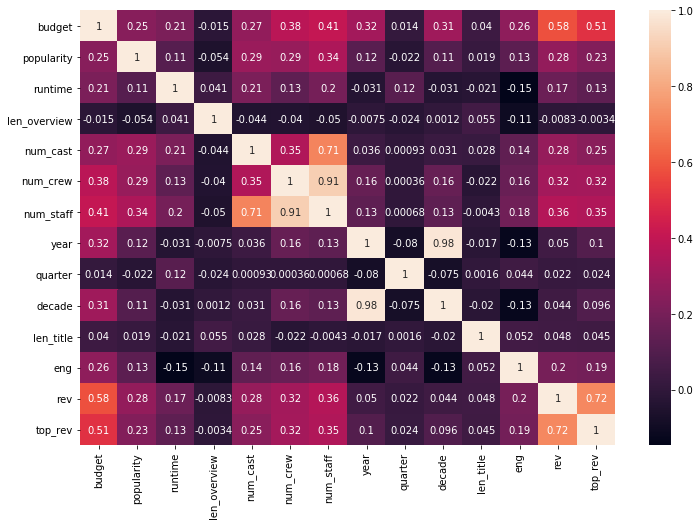

In [24]:
plt.figure(figsize = (12,8))
ax = sns.heatmap(df.corr(),annot=True)

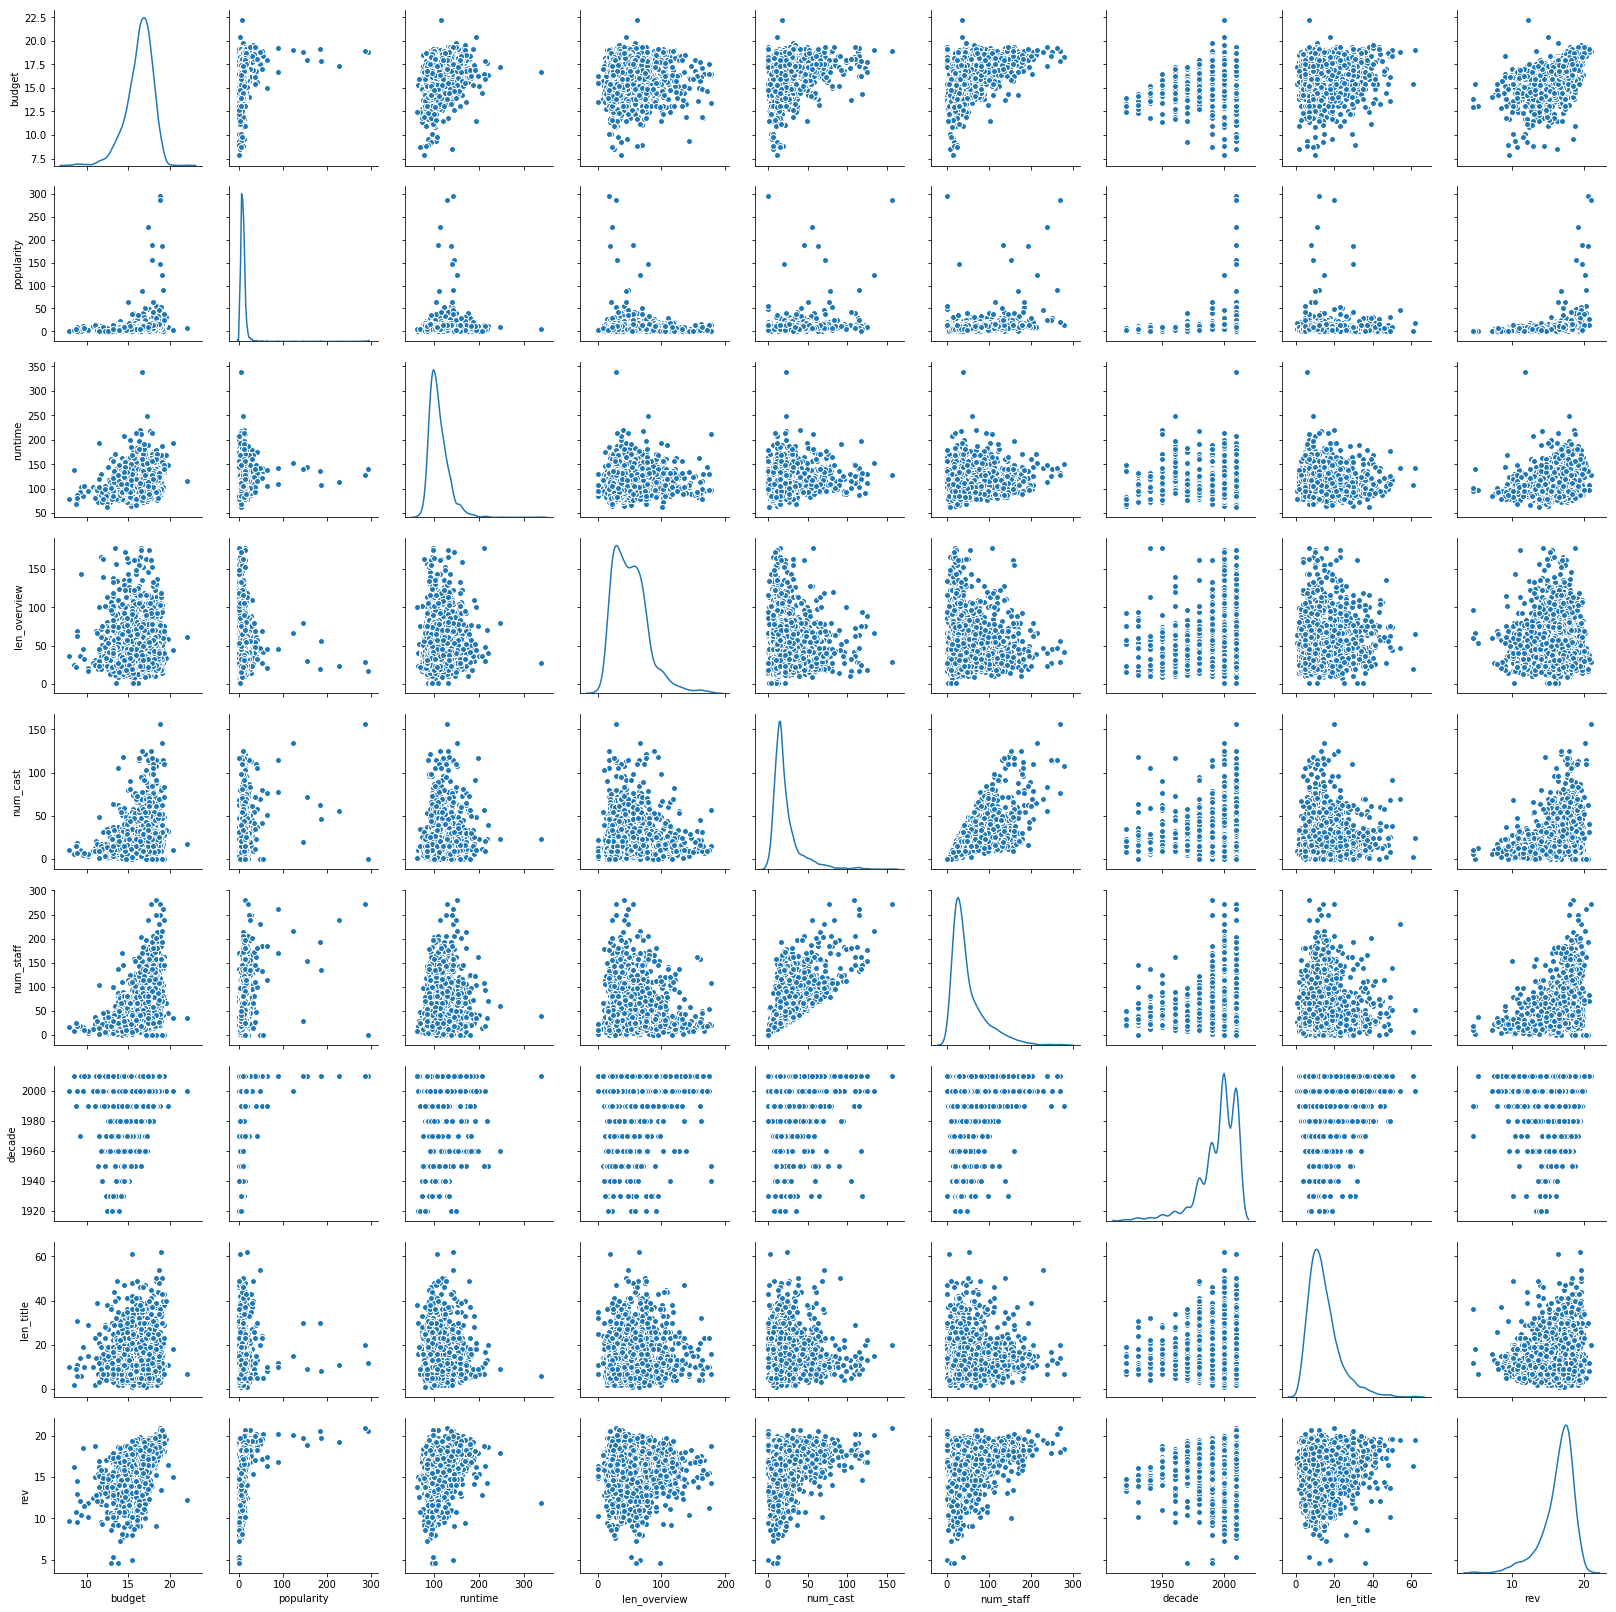

In [25]:
sns.pairplot(df.drop(['num_crew','year','eng','top_rev','quarter'],axis=1), diag_kind = 'kde')#, hue = "top_rev"))

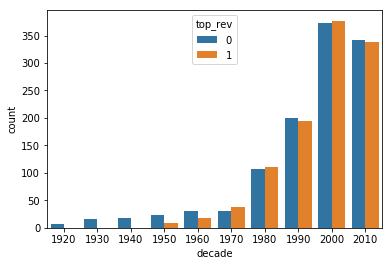

In [26]:
sns.countplot(x='decade', hue='top_rev', data=df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002561DB5FC50>,
      dtype=object)

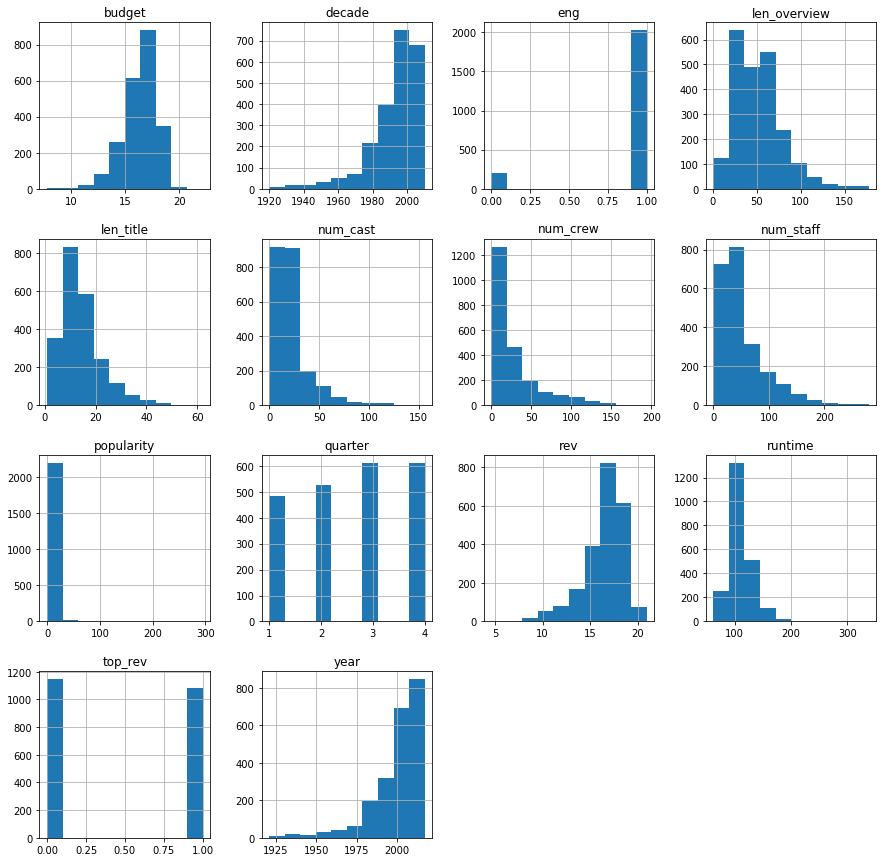

In [27]:
df.hist(figsize=(15,15))

### Feature Engineering

In [28]:
count_cats = ['spoken','genres','cast','director','exec_producer','producer','companies','countries','keywords','overview']
counts = {}

df =df_all.copy()
test=test_all.copy()
both = pd.concat([df.copy(), test.copy()], axis=0).drop(['rev'],axis=1)

for i in count_cats:
    counts[i]=Counter(itertools.chain.from_iterable(both[i])).most_common()#[:15]
    
counters = [counts[count_cats[0]][:10],counts[count_cats[1]][:10], counts[count_cats[2]][:100], counts[count_cats[3]][:50], counts[count_cats[4]][:50],counts[count_cats[5]][:50],counts[count_cats[6]][:20],counts[count_cats[7]][:15],counts[count_cats[8]][:20],counts[count_cats[9]][28:50]]

mains = []
for i in counters:
    mains.append([m[0] for m in i])
    
def get_mains(d):
    for i in range(len(mains)):
        d[count_cats[i]] = d.loc[d[count_cats[i]].notnull(),count_cats[i]].apply(lambda x: [y for y in x if y in mains[i]])
    
    d['num_cast']=d.cast.apply(len)
    d['num_languages'] = d.spoken.apply(len)
    d['num_genres'] = d.genres.apply(len)
    d['num_keywords'] = d.keywords.apply(len)
    d['num_companies'] = d.companies.apply(len)
    d['num_countries'] = d.countries.apply(len)
    
    d=d.merge(pd.get_dummies(d['genres'].apply(pd.Series).stack()).sum(level=0),left_index=True,right_index=True, how='left')
    d=d.merge(pd.get_dummies(d['spoken'].apply(pd.Series).stack()).sum(level=0),left_index=True,right_index=True, how='left')
    d=d.merge(pd.get_dummies(d['keywords'].apply(pd.Series).stack()).sum(level=0),left_index=True,right_index=True, how='left')
    
    
    d=d.drop(['genres','spoken','keywords','eng'],axis=1)
    d.fillna(0, inplace=True)
    
    return d

nums = ['num_languages','num_genres','num_keywords','num_companies','num_countries','num_cast']

df=get_mains(df)
test=get_mains(test)

df_d =df.copy()
test_d=test.copy()
both_d = pd.concat([df.copy(), test.copy()], axis=0).drop(['rev','top_rev'],axis=1)

#df.info()
#test.info()
both.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 1 to 7398
Data columns (total 26 columns):
budget           5486 non-null float64
cast             7398 non-null object
collection       7398 non-null object
companies        7398 non-null object
countries        7398 non-null object
decade           7398 non-null int64
director         7398 non-null object
eng              7398 non-null bool
exec_producer    7398 non-null object
genres           7398 non-null object
keywords         7398 non-null object
language         7398 non-null object
len_overview     7398 non-null int64
len_title        7398 non-null int64
num_cast         7398 non-null int64
num_crew         7398 non-null int64
num_staff        7398 non-null int64
overview         7398 non-null object
popularity       7398 non-null float64
producer         7398 non-null object
quarter          7398 non-null int64
runtime          7398 non-null float64
spoken           7398 non-null object
title            7398 non

,collection,budget,language,overview,popularity,companies,countries,runtime,title,cast,len_overview,num_cast,num_crew,num_staff,director,producer,exec_producer,year,quarter,decade,len_title,rev,top_rev,num_languages,num_genres,num_keywords,num_companies,num_countries,Action,Adventure,Comedy,Crime,Drama,Family,Horror,Romance,Science Fiction,Thriller,ar,de,en,es,fr,hi,it,ja,ru,zh,aftercreditsstinger,based on novel,biography,duringcreditsstinger,dystopia,friendship,independent film,love,murder,musical,nudity,police,revenge,sequel,sex,sport,suspense,teenager,violence,woman director
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Hot Tub Time Machine Collection,16.454568,en,[up],6.575393,"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],93.0,Hot Tub Time Machine 2,[],29,0,72,96,[],[],[],2015,1,2010,22,16.323701,0,1,1,2,3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,The Princess Diaries Collection,17.504390,en,"[up, life]",8.248895,[Walt Disney Pictures],[United States of America],113.0,The Princess Diaries 2: Royal Engagement,[],69,0,9,29,[Garry Marshall],[],[],2004,3,2000,40,18.370959,1,1,4,0,1,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,15.009433,en,[young],64.299990,[],[United States of America],105.0,Whiplash,[],21,0,64,115,[],[Jason Blum],[],2014,4,2010,8,16.387512,0,1,1,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,13.997833,hi,"[about, all, it, about, , , life]",3.174936,[],[India],122.0,Kahaani,[],106,0,3,10,[],[],[],2012,1,2010,7,16.588099,0,2,2,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.000000,ko,"[story, out]",1.148070,[],[],118.0,Marine Boy,[],32,0,2,6,[],[],[],2009,1,2000,4,15.182615,0,0,2,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#data checkpoint

df = df_d.copy()
test = test_d.copy()
both = both_d.copy()


df.to_csv(path_or_buf='train_clean.csv')
test.to_csv(path_or_buf='test_clean.csv')


In [30]:
df = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')

df.index = df['id']
test.index = test['id']

df.drop('id', axis=1,inplace=True)
test.drop('id',axis=1,inplace=True)

df.collection=df.collection.apply(lambda x: 0 if (x=='0') else 1)
test.collection=test.collection.apply(lambda x: 0 if (x=='0') else 1)

both = pd.concat([df, test], axis=0).drop(['rev','top_rev'], axis=1)

both.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7398 entries, 1 to 7398
Data columns (total 66 columns):
Action                  7398 non-null float64
Adventure               7398 non-null float64
Comedy                  7398 non-null float64
Crime                   7398 non-null float64
Drama                   7398 non-null float64
Family                  7398 non-null float64
Horror                  7398 non-null float64
Romance                 7398 non-null float64
Science Fiction         7398 non-null float64
Thriller                7398 non-null float64
aftercreditsstinger     7398 non-null float64
ar                      7398 non-null float64
based on novel          7398 non-null float64
biography               7398 non-null float64
budget                  7398 non-null float64
cast                    7398 non-null object
collection              7398 non-null int64
companies               7398 non-null object
countries               7398 non-null object
de                      

,collection,budget,language,overview,popularity,companies,countries,runtime,title,cast,len_overview,num_cast,num_crew,num_staff,director,producer,exec_producer,year,quarter,decade,len_title,rev,top_rev,num_languages,num_genres,num_keywords,num_companies,num_countries,Action,Adventure,Comedy,Crime,Drama,Family,Horror,Romance,Science Fiction,Thriller,ar,de,en,es,fr,hi,it,ja,ru,zh,aftercreditsstinger,based on novel,biography,duringcreditsstinger,dystopia,friendship,independent film,love,murder,musical,nudity,police,revenge,sequel,sex,sport,suspense,teenager,violence,woman director
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,16.454568,en,['up'],6.575393,"['Paramount Pictures', 'United Artists', 'Metr...",['United States of America'],93.0,Hot Tub Time Machine 2,[],29,0,72,96,[],[],[],2015,1,2010,22,16.323701,0,1,1,2,3,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,17.504390,en,"['up', 'life']",8.248895,['Walt Disney Pictures'],['United States of America'],113.0,The Princess Diaries 2: Royal Engagement,[],69,0,9,29,['Garry Marshall'],[],[],2004,3,2000,40,18.370959,1,1,4,0,1,1,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,15.009433,en,['young'],64.299990,[],['United States of America'],105.0,Whiplash,[],21,0,64,115,[],['Jason Blum'],[],2014,4,2010,8,16.387512,0,1,1,1,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,13.997833,hi,"['about', 'all', 'it', 'about', '', '', 'life']",3.174936,[],['India'],122.0,Kahaani,[],106,0,3,10,[],[],[],2012,1,2010,7,16.588099,0,2,2,0,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0.000000,ko,"['story', 'out']",1.148070,[],[],118.0,Marine Boy,[],32,0,2,6,[],[],[],2009,1,2000,4,15.182615,0,0,2,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Descriptive Statistics

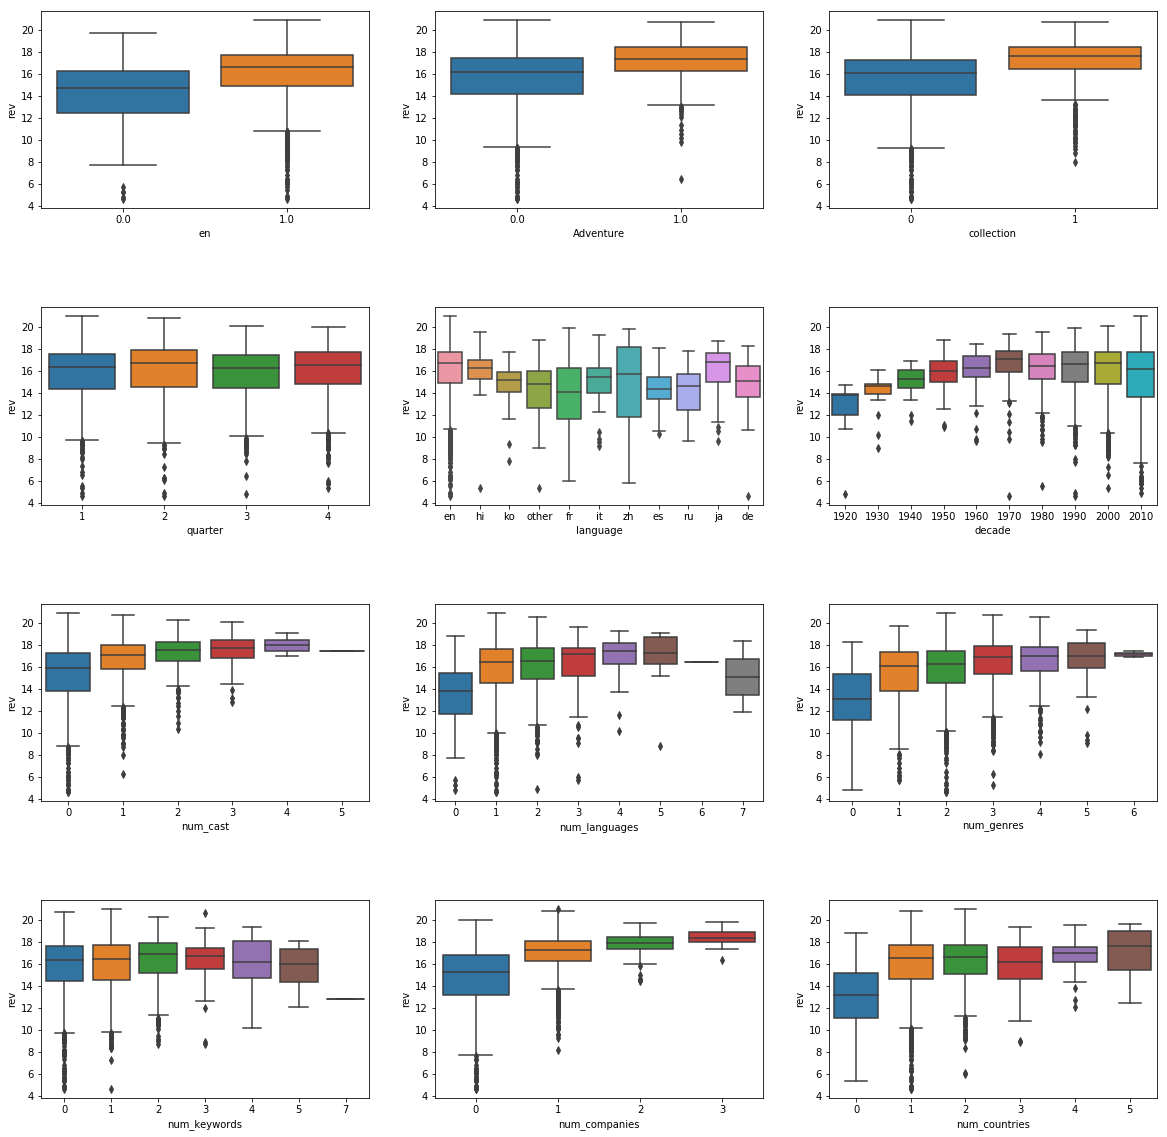

In [31]:
h=4
w=3
#'num_staff','len_overview','len_title'
cats = ['en','Adventure','collection','quarter','language','decade','num_cast','num_languages','num_genres','num_keywords','num_companies','num_countries']
fig, axs = plt.subplots(h,w,figsize= [20, 20])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

for i in range(len(cats)):
    sns.boxplot(x=cats[i], y='rev', data=df, ax=axs[int(np.floor(i/w))][i%w])

### Feature Selection

In [32]:
cat_cols = [cname for cname in test.columns if test[cname].dtype=='object']
num_cols = [cname for cname in test.columns if test[cname].dtype in ['int64', 'float64']]
all_cols = cat_cols + num_cols

features = df[num_cols].drop(['num_crew','decade'],axis=1)
labels = df.rev

In [33]:
rf = RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=3,max_features=4)
rf.fit(features,labels)
feature_importances = pd.DataFrame(rf.feature_importances_,index = features.columns,columns=['importance']).sort_values('importance', ascending=False)
rf_features = df[feature_importances.head(15).index]
rf_features.head()

,budget,popularity,num_companies,num_staff,runtime,year,collection,num_cast,len_overview,len_title,num_genres,num_countries,Adventure,en,quarter
id,,,,,,,,,,,,,,,
1,16.454568,6.575393,3,96,93.0,2015,1,0,29,22,1,1,0.0,1.0,1
2,17.504390,8.248895,1,29,113.0,2004,1,0,69,40,4,1,0.0,1.0,3
3,15.009433,64.299990,0,115,105.0,2014,0,0,21,8,1,1,0.0,1.0,4
4,13.997833,3.174936,0,10,122.0,2012,0,0,106,7,2,1,0.0,1.0,1
5,0.000000,1.148070,0,6,118.0,2009,0,0,32,4,2,0,0.0,0.0,1


[[ 1.19320433e-03  6.82235134e-02  1.28868430e-01  1.58042607e-01
  -1.02031220e-01  4.61022497e-03  9.69561563e-01  5.62606311e-02
   7.53899402e-04 -7.05434509e-03  2.28688605e-03  3.48060101e-03
   2.35188773e-03  3.99248585e-03  2.78876691e-03  1.95354545e-03
   1.17979303e-03 -1.38039922e-03  6.67646458e-04 -3.40630250e-04
  -1.66918545e-04  1.44863756e-04 -9.07084563e-04  8.17123801e-04
   1.51266109e-03  1.40050777e-04  1.72331852e-04  1.64616185e-03
   3.30978394e-04  1.21764436e-04 -1.63738366e-04  1.29751554e-04
   3.94800313e-05 -1.23272814e-04 -6.62166064e-06  5.23971912e-04
   5.34013151e-04  2.35661398e-04  4.77241164e-04  4.28673566e-04
   4.50694395e-05 -5.64763481e-04 -2.93601900e-05  2.02377501e-04
  -7.45050211e-05 -3.75197514e-06  6.26072907e-05  1.77587547e-04
   3.05556932e-04  2.15349607e-05 -5.45025597e-05  2.42953362e-05
   6.27276192e-05  2.87828447e-04 -3.10375304e-04]
 [ 5.09342994e-04  1.63818271e-03 -3.37120050e-03  7.68060863e-02
   9.92507304e-01 -8.3660

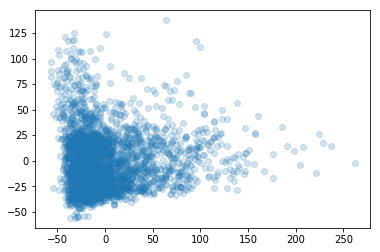

[0.46736628 0.25205425 0.13050598]


In [34]:
###PCA

X_reduced = PCA(n_components=3).fit_transform(features)
pca = PCA(n_components=3)
pca.fit(features)
# plot data
plt.scatter(X_reduced[:, 0], X_reduced[:, 1],alpha=0.2)
print(pca.components_)
#print(pca.explained_variance_)
#print(pca.mean_)
#print(np.matrix.transpose(pca.components_))
    
plt.show()

print(pca.explained_variance_ratio_)

In [35]:
feature_df = pd.DataFrame({'feature': features.columns, 'importance': abs( pca.components_[0])})
feature_df.sort_values(by='importance', ascending=False, inplace=True)

pca_features = df[feature_df.feature[:15]]
pca_features.head()

,num_staff,runtime,popularity,len_overview,budget,year,len_title,num_cast,num_companies,num_genres,num_countries,num_keywords,num_languages,Action,en
id,,,,,,,,,,,,,,,
1,96,93.0,6.575393,29,16.454568,2015,22,0,3,1,1,2,1,0.0,1.0
2,29,113.0,8.248895,69,17.504390,2004,40,0,1,4,1,0,1,0.0,1.0
3,115,105.0,64.299990,21,15.009433,2014,8,0,0,1,1,1,1,0.0,1.0
4,10,122.0,3.174936,106,13.997833,2012,7,0,0,2,1,0,2,0.0,1.0
5,6,118.0,1.148070,32,0.000000,2009,4,0,0,2,0,0,0,1.0,0.0


In [36]:
corr_features= df[df.corr().abs()['rev'].sort_values(ascending=False).head(18).index].drop(['rev','top_rev','num_crew'],axis=1)

corr_features.head()

,budget,num_companies,num_staff,popularity,num_cast,collection,en,Adventure,runtime,num_genres,Action,independent film,Family,Drama,num_countries
id,,,,,,,,,,,,,,,
1,16.454568,3,96,6.575393,0,1,1.0,0.0,93.0,1,0.0,0.0,0.0,0.0,1
2,17.504390,1,29,8.248895,0,1,1.0,0.0,113.0,4,0.0,0.0,1.0,1.0,1
3,15.009433,0,115,64.299990,0,0,1.0,0.0,105.0,1,0.0,0.0,0.0,1.0,1
4,13.997833,0,10,3.174936,0,0,1.0,0.0,122.0,2,0.0,0.0,0.0,1.0,1
5,0.000000,0,6,1.148070,0,0,0.0,0.0,118.0,2,1.0,0.0,0.0,0.0,0


### Predict and Evaluate

In [37]:
#Split data

x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state = 42)

#num_transformer = Imputer(strategy='mean')
#cat_transformer= Pipeline(steps=[('imputer',Imputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
#preprocessor = ColumnTransformer(transformers=[('num',num_transformer,num_cols),('cat',cat_transformer,cat_cols)])

gb = xgb.XGBRegressor(n_estimators=100,learning_rate = 0.05)
rf = RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=3,max_features=4)
lr = LinearRegression(fit_intercept = True)

#gb_pl = Pipeline(steps=[('preprocessor', preprocessor),('xgb',gb)])
#rf_pl = Pipeline(steps=[('preprocessor', preprocessor),('randomforest',rf)])

#xgb_pl.fit(x_train,y_train)
#rf_pl.fit(x_train,y_train)

gb.fit(x_train,y_train)
rf.fit(x_train,y_train)
lr.fit(x_train,y_train)

gb_pred = gb.predict(x_test)
rf_pred = rf.predict(x_test)
lr_pred = lr.predict(x_test)

rmsle_rf = np.sqrt(mean_squared_error(rf_pred,y_test))
rmsle_gb = np.sqrt(mean_squared_error(gb_pred,y_test))
rmsle_lr = np.sqrt(mean_squared_error(lr_pred,y_test))

print('Using all features:\n\n''rf: '+str(rmsle_rf)+'\n\nxgb: '+str(rmsle_gb)+'\n\nlr: '+str(rmsle_lr))

Using all features:

rf: 1.7542059089082067

xgb: 1.7086518731308828

lr: 1.8456194841658726


In [38]:
#Split data

x_train, x_test, y_train, y_test = train_test_split(rf_features, labels, random_state = 42)

#num_transformer = Imputer(strategy='mean')
#cat_transformer= Pipeline(steps=[('imputer',Imputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
#preprocessor = ColumnTransformer(transformers=[('num',num_transformer,num_cols),('cat',cat_transformer,cat_cols)])

gb = xgb.XGBRegressor(n_estimators=100,learning_rate = 0.05)
rf = RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=3,max_features=4)
lr = LinearRegression(fit_intercept = True)

#gb_pl = Pipeline(steps=[('preprocessor', preprocessor),('xgb',gb)])
#rf_pl = Pipeline(steps=[('preprocessor', preprocessor),('randomforest',rf)])

#xgb_pl.fit(x_train,y_train)
#rf_pl.fit(x_train,y_train)

gb.fit(x_train,y_train)
rf.fit(x_train,y_train)
lr.fit(x_train,y_train)

gb_pred = gb.predict(x_test)
rf_pred = rf.predict(x_test)
lr_pred = lr.predict(x_test)

rmsle_rf = np.sqrt(mean_squared_error(rf_pred,y_test))
rmsle_gb = np.sqrt(mean_squared_error(gb_pred,y_test))
rmsle_lr = np.sqrt(mean_squared_error(lr_pred,y_test))

print('Using rf features:\n\n''rf: '+str(rmsle_rf)+'\n\nxgb: '+str(rmsle_gb)+'\n\nlr: '+str(rmsle_lr))

Using rf features:

rf: 1.7089349458215157

xgb: 1.7414557852020527

lr: 1.9024361337584215


In [39]:
#Split data

x_train, x_test, y_train, y_test = train_test_split(pca_features, labels, random_state = 42)

#num_transformer = Imputer(strategy='mean')
#cat_transformer= Pipeline(steps=[('imputer',Imputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
#preprocessor = ColumnTransformer(transformers=[('num',num_transformer,num_cols),('cat',cat_transformer,cat_cols)])

gb = xgb.XGBRegressor(n_estimators=100,learning_rate = 0.05)
rf = RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=3,max_features=4)
lr = LinearRegression(fit_intercept = True)

#gb_pl = Pipeline(steps=[('preprocessor', preprocessor),('xgb',gb)])
#rf_pl = Pipeline(steps=[('preprocessor', preprocessor),('randomforest',rf)])

#xgb_pl.fit(x_train,y_train)
#rf_pl.fit(x_train,y_train)

gb.fit(x_train,y_train)
rf.fit(x_train,y_train)
lr.fit(x_train,y_train)

gb_pred = gb.predict(x_test)
rf_pred = rf.predict(x_test)
lr_pred = lr.predict(x_test)

rmsle_rf = np.sqrt(mean_squared_error(rf_pred,y_test))
rmsle_gb = np.sqrt(mean_squared_error(gb_pred,y_test))
rmsle_lr = np.sqrt(mean_squared_error(lr_pred,y_test))

print('Using pca features:\n\n''rf: '+str(rmsle_rf)+'\n\nxgb: '+str(rmsle_gb)+'\n\nlr: '+str(rmsle_lr))

Using pca features:

rf: 1.755544309531299

xgb: 1.7535945664179182

lr: 1.9617650097806485


In [40]:
#Split data

x_train, x_test, y_train, y_test = train_test_split(corr_features, labels, random_state = 42)

#num_transformer = Imputer(strategy='mean')
#cat_transformer= Pipeline(steps=[('imputer',Imputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
#preprocessor = ColumnTransformer(transformers=[('num',num_transformer,num_cols),('cat',cat_transformer,cat_cols)])

gb = xgb.XGBRegressor(n_estimators=100,learning_rate = 0.05)
rf = RandomForestRegressor(n_estimators=100,min_samples_split=5,min_samples_leaf=3,max_features=4)
lr = LinearRegression(fit_intercept = True)

#gb_pl = Pipeline(steps=[('preprocessor', preprocessor),('xgb',gb)])
#rf_pl = Pipeline(steps=[('preprocessor', preprocessor),('randomforest',rf)])

#xgb_pl.fit(x_train,y_train)
#rf_pl.fit(x_train,y_train)

gb.fit(x_train,y_train)
rf.fit(x_train,y_train)
lr.fit(x_train,y_train)

gb_pred = gb.predict(x_test)
rf_pred = rf.predict(x_test)
lr_pred = lr.predict(x_test)

rmsle_rf = np.sqrt(mean_squared_error(rf_pred,y_test))
rmsle_gb = np.sqrt(mean_squared_error(gb_pred,y_test))
rmsle_lr = np.sqrt(mean_squared_error(lr_pred,y_test))

print('Using corr features:\n\n''rf: '+str(rmsle_rf)+'\n\nxgb: '+str(rmsle_gb)+'\n\nlr: '+str(rmsle_lr))

Using corr features:

rf: 1.7223794357115707

xgb: 1.7514899595847822

lr: 1.8555859656164335
